In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = torch.device ("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Load CIFAR-10 dataset
batch_size = 256
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to fit ViT input
    transforms.ToTensor(),           # Convert to Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size= batch_size, shuffle=False)

100%|██████████| 169001437/169001437 [00:04<00:00, 39382337.59it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Load the pretrained ViT model
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=100)
model = model.to(device)
# Freeze the backbone layers
for param in model.vit.parameters():
    param.requires_grad = False

# Only train the classifier head
for param in model.classifier.parameters():
    param.requires_grad = True

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
num_epochs = 3
train_accuracy_list = []
test_accuracy_list = []

In [15]:
def train(model, train_loader, criterion, optimizer, device):
        model.train()
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images).logits  # Get the logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train
        train_accuracy_list.append(train_accuracy)
        return train_accuracy, loss

In [16]:
def test(model, test_loader, device):
    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = correct_test / total_test
    test_accuracy_list.append(test_accuracy)
    return test_accuracy

In [17]:
for i in tqdm(range(num_epochs)):
    train_accuracy, loss = train(model, train_loader, criterion, optimizer, device)
    print(f'Epoch [{i+1}/{num_epochs}], Training Accuracy: {train_accuracy:.4f}, Loss: {loss.item():.4f}')
    test_accuracy = test(model, test_loader, device)
    print(f'Testing Accuracy: {test_accuracy:.4f}')

100%|██████████| 196/196 [10:25<00:00,  3.19s/it]


Epoch [1/3], Training Accuracy: 0.8609, Loss: 0.5282


 33%|███▎      | 1/3 [12:30<25:00, 750.37s/it]

Testing Accuracy: 0.8477



100%|██████████| 196/196 [10:27<00:00,  3.20s/it]


Epoch [2/3], Training Accuracy: 0.8679, Loss: 0.4230


 67%|██████▋   | 2/3 [25:03<12:31, 751.99s/it]

Testing Accuracy: 0.8496



100%|██████████| 196/196 [10:26<00:00,  3.20s/it]


Epoch [3/3], Training Accuracy: 0.8754, Loss: 0.5048


100%|██████████| 3/3 [37:33<00:00, 751.33s/it]

Testing Accuracy: 0.8512


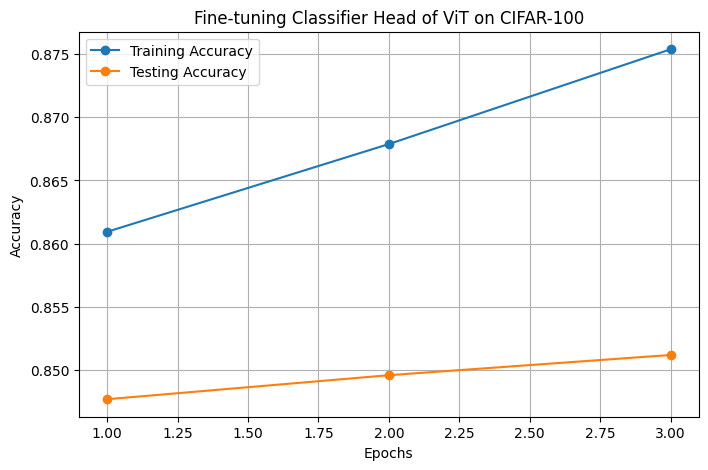

In [18]:
# Plotting the accuracy curves
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_accuracy_list, label='Training Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), test_accuracy_list, label='Testing Accuracy', marker='o')
plt.title('Fine-tuning Classifier Head of ViT on CIFAR-100')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()